In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import time
import serology
import distributions.priors as priors
import ndes.ndes as ndes
import ndes.train as train
import tensorflow as tf
import pickle
import emcee
%matplotlib inline

In [ ]:
# Create serology simulator object
Model = serology.Serology()

In [ ]:
# Create the neural density estimator

n_parameters = 10
n_antibodies = 1

NDE = ndes.MixtureDensityNetwork(n_inputs=n_parameters + 1 + 1, # serology parameters + age + log_EIR 
                                 n_outputs=n_antibodies, 
                                 n_components=3, 
                                 n_hidden=[27, 27, 27, 27, 27, 27, 27], 
                                 activations=[tf.tanh, tf.tanh, tf.tanh, tf.tanh, tf.tanh, tf.tanh, tf.tanh])

# Create a trainer
Trainer = train.ConditionalTrainer(NDE)

# Start a tensorflow session
sess = tf.Session(config = tf.ConfigProto())
sess.run(tf.global_variables_initializer())

In [4]:
# Load in the simulations for training

# tf placeholders for training data
x_train = tf.placeholder(tf.float32, shape = (None, n_antibodies)) # data
y_train = tf.placeholder(tf.float32, shape = (None, n_parameters+1)) # parameters

# Load in the simulations
xs = pickle.load(open('simulations/model_2/xs.pkl', 'rb'))
ps = pickle.load(open('simulations/model_2/ps.pkl', 'rb'))

# Re-scale everything
x_batch_mean = np.mean(xs, axis = 0)
x_batch_stddev = np.std(xs, axis = 0)
p_batch_mean = np.mean(ps, axis = 0)
p_batch_stddev = np.std(ps, axis = 0)

ps_normalized = (ps - p_batch_mean)/p_batch_stddev
xs_normalized = (xs - x_batch_mean)/x_batch_stddev

x_train = ps_normalized.astype(np.float32)
y_train = xs_normalized.astype(np.float32)

In [9]:
# Train the MDN on these simulations
validation_loss, training_loss = Trainer.train(sess, [x_train, y_train], validation_split = 0.1, epochs = 25,
                  patience=20, saver_name='tmp_model')

INFO:tensorflow:Restoring parameters from ./tmp_model


In [10]:
# Save the batch normalizations
f = open('simulations/model_2/batch_normalizations.pkl', 'wb')
pickle.dump([x_batch_mean, x_batch_stddev, p_batch_mean, p_batch_stddev], f)
f.close()

In [11]:
# Weights and biases of the network
f = open('simulations/model_2/network_weights.pkl', 'wb')
pickle.dump(sess.run(NDE.weights), f)
f.close()
f = open('simulations/model_2/network_biases.pkl', 'wb')
pickle.dump(sess.run(NDE.biases), f)
f.close()

c:\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


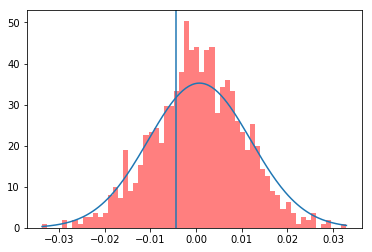

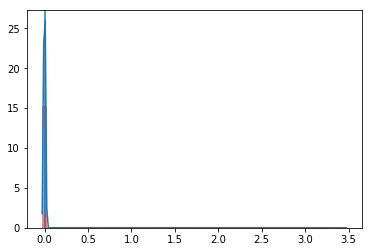

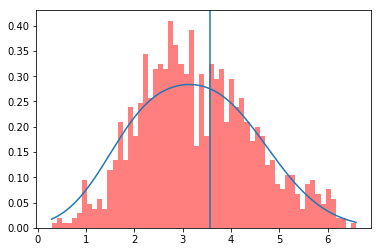

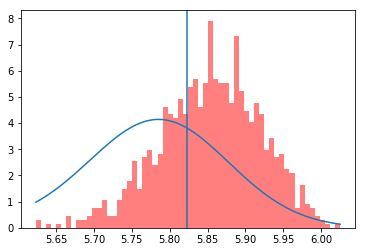

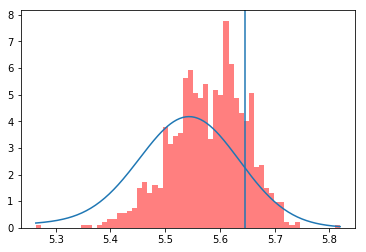

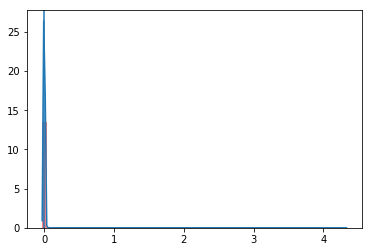

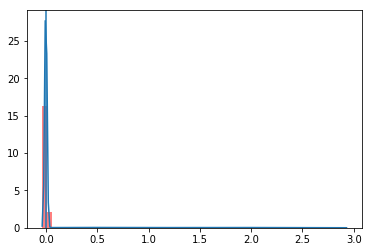

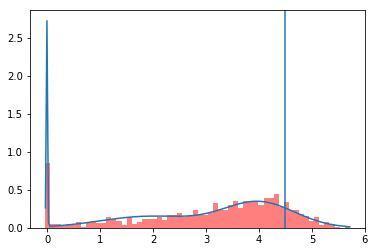

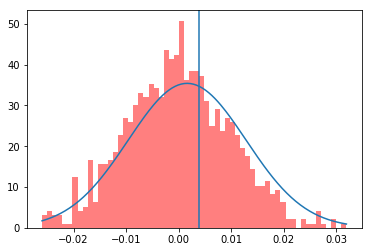

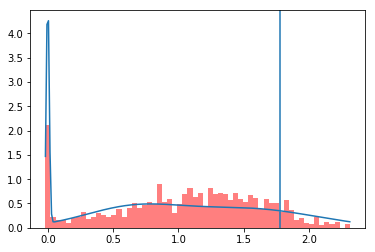

In [12]:
### COMPARE THE LEARNED SAMPLING DISTRIBUTION TO THE SIMULATIONS ###

### SET UP PRIORS OVER PARAMETERS ###

# Lower limits
theta_lower = np.array([  0, # fzero
                          0, # gzero
                          5, # azero
                          np.log(0.05), # logHetBoosting
                          np.log(10), # logBaselineBoostingFactor
                          np.log(10), # logBaselineBoostingThreshold
                          np.log(0.05), # logAttenuationFactor
                          2,# NAdultAntibodies
                          np.log(0.01), # logRhoChild
                          np.log(0.01) # logRhoAdultExtra
                          ])
# Upper limits
theta_upper = np.array([  1, # fzero
                          1, # gzero
                          35, # azero
                          np.log(4), # logHetBoosting
                          np.log(30000), # logBaselineBoostingFactor
                          np.log(10000), # logBaselineBoostingThreshold
                          np.log(4), # logAttenuationFactor
                          20,# NAdultAntibodies
                          np.log(10), # logRhoChild
                          np.log(20) # logRhoAdultExtra
                          ])

theta_prior = priors.Uniform(lower=theta_lower, upper=theta_upper)
log_eir_prior = priors.Uniform(lower=np.log(5e-3), upper=np.log(50))

# Draw some realizations of parameters from the prior, simulate, compare to learned sampling distribution
for k in range(10):
    #theta = #theta_prior.draw()
    #log_eir = #log_eir_prior.draw()
    #age = np.random.randint(1, 51)
    #params = (np.concatenate([np.atleast_1d(log_eir), theta[0:10], np.atleast_1d(age)]) - p_batch_mean)/p_batch_stddev
    iran = np.random.randint(0,2000000)
    xobs = xs[iran,]
    params = ps[iran,]
    params_norm = (params-p_batch_mean)/p_batch_stddev
    
    # Draw samples from the model (simulator) for comparison
    #samples = np.array([Model.simulate(log_eir, theta[0:10], age) for i in range(1000)])
    samples = np.array([Model.simulate(params[0],params[1:11],params[11]) for i in range(1000)])
    samples[samples < 1.0] = 1.0
    samples = np.log(samples + np.random.normal(loc=0.0,scale=0.01,size=1000))
    
    d = np.linspace(min(samples), max(samples), 200)
    pdf = np.array([np.exp(NDE.eval((np.atleast_2d(params_norm), np.atleast_2d((d[i]-x_batch_mean)/x_batch_stddev )), sess))/x_batch_stddev for i in range(len(d))])

    # Plot their distributions to compare
    plt.hist(samples, bins = 60, normed=True, color = 'red', alpha=0.5)
    plt.plot(d, pdf)
    plt.axvline(x=xobs)
    #plt.xlim(0,10)
    plt.show()